# Tuning Hyperparameters using Bayesian Search

The Bayesian Search package from https://github.com/fmfn/BayesianOptimization was used. In examples https://github.com/fmfn/BayesianOptimization/tree/master/examples there is a lot of guidance on how to set up the search.

# Step 1: Importing all required functions and importing the data. 

In [267]:
import handle_data
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from bayes_opt import BayesianOptimization, UtilityFunction, SequentialDomainReductionTransformer
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from yellowbrick.regressor import ResidualsPlot

In [268]:
variable_to_predict = "TotalExpenditure"

In [269]:
def import_data(desired_features = None):
    # Import the data
    data = handle_data.csv_to_dataframe("logfiles.csv")
    
    include_checkin = True
    include_security = True
    exclude_below_025_percent_importance = False
    only_total = True
    no_call_to_gate = True

    
    data = handle_data.strategies(data, "check_in_strategies.csv", "security_strategies.csv", include_checkin=include_checkin, include_security=include_security, replace=True)
    
    # Remove outliers from training and val
    data = handle_data.remove_faulty(data, variable_to_predict, 1.5, ["INI", "ADA", "HO", 'VAL'])
    
    # Feature engineering
    data["Input"]["TotalPassengers"] = data["Input"]['NumberPaxFlight1'] + data["Input"]['NumberPaxFlight2'] + data["Input"]['NumberPaxFlight3'] + data["Input"]['NumberPaxFlight4'] + data["Input"]['NumberPaxFlight5'] + data["Input"]['NumberPaxFlight6'] + data["Input"]['NumberPaxFlight7']
    if include_checkin:
#         data["Input"]["CheckinCountersPerPassenger"] = data["Input"]["TotalCheckinCounters"] / data["Input"]["TotalPassengers"]
        data["Input"]["TotalCheckinCounters"] = data["Input"]["C7200-6300"] + data["Input"]["C6300-5400"] + data["Input"]["C5400-4500"] + data["Input"]['C4500-3600'] + data["Input"]['C3600-2700']
    if include_security:
        data["Input"]["TotalSecurityLanes"] = 8 + data["Input"]["S<1800"] + data["Input"]["S1800-3600"] + data["Input"]["S7200-9000"] + data["Input"]['S9000-10800'] + data["Input"]['S>10800']
        #data["Input"]["SecurityLanesPerPassenger"] = data["Input"]["TotalSecurityLanes"] / data["Input"]["TotalPassengers"]
    if exclude_below_025_percent_importance:
        del data["Input"]['S<1800']
        del data["Input"]["TotalCheckinCounters"]
        del data["Input"]["S>10800"]
        del data["Input"]["C7200-6300"]
        del data["Input"]["C4500-3600"]
        del data["Input"]["C6300-5400"]
        del data["Input"]["C5400-4500"]
        del data["Input"]["C3600-2700"]
    if only_total:
        # del data["Input"]['S<1800']
        # del data["Input"]["S>10800"]
        # del data["Input"]["C7200-6300"]
        # del data["Input"]["C4500-3600"]
        # del data["Input"]["C6300-5400"]
        # del data["Input"]["C5400-4500"]
        # del data["Input"]["C3600-2700"]
        # del data["Input"]["S1800-3600"]
        # del data["Input"]["S9000-10800"]
        # del data["Input"]["S7200-9000"]
        del data["Input"]["NumberPaxFlight1"]
        del data["Input"]["NumberPaxFlight2"]
        del data["Input"]["NumberPaxFlight3"]
        del data["Input"]["NumberPaxFlight4"]
        del data["Input"]["NumberPaxFlight5"]
        del data["Input"]["NumberPaxFlight6"]
        del data["Input"]["NumberPaxFlight7"]
    if no_call_to_gate:
        data["Input"]["CallToGateStrategy"] = np.log(data["Input"]["CallToGateStrategy"])
        data["Input"]["TotalPassengers"] = np.log(data["Input"]["TotalPassengers"])

    training, val, test = handle_data.split_data(data)
    
    training = handle_data.manipulate_data(training)
    val = handle_data.manipulate_data(val)
    test = handle_data.manipulate_data(test)
    
    if desired_features != None:
        training["Input"] = training["Input"][desired_features]
        val["Input"] = val["Input"][desired_features]
        test["Input"] = test["Input"][desired_features]
    

    
    return training, val, test

In [270]:
# desired_features = ["CallToGateStrategy", "S1800-3600", "NumberPaxFlight7"]
desired_features = None
training, val, test = import_data(desired_features)
print(training["Input"].shape)
n_features = training["Input"].shape[1]
print(n_features)

[DEBUG] Reading logfiles.csv into dataframe
[DEBUG] Finished reading logfiles.csv into dataframe after 0.8848333358764648 seconds
        AvgQueueTime_Cl1  AvgQueueTime_Cl2  AvgQueueTime_Cl3  \
0             146.746667        272.372840        184.104082   
1             148.725974        143.750000        225.565854   
2             139.027273        119.156250        163.432558   
3             123.202439        158.963514        398.334211   
4             157.583582        112.339474        259.441026   
...                  ...               ...               ...   
127903        125.503000        159.863095        217.073333   
127904        185.470833        177.438938        247.737500   
127905        199.926496        178.959596        262.635849   
127906        186.985227        188.323077        262.325424   
127907         94.430108        377.495833        250.300000   

        AvgQueueTime_Cl4  AvgQueueTime_SC  AvgTimeToGate  PaxCompleted_SC  \
0             116.633333

# Step 2: Setting up the objective function and search algorithm.

In rf_model the objective function to maximise is setup. Note the error is multiplied by -1 as the function is maximised but the error has to be minimised.

For integer hyperparameter, the number is rounded to an integer.

In tune_hyperparameters_bayes the searching grid is set up, as well as the bayes searching algorithm. The results of the Bayes search are automatically logged into the "bayes_logs" folder, so it can be re-used later if further searching is required.

In [271]:
def rf_model(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    params_rf = {}
    params_rf['n_estimators'] = round(n_estimators)
    params_rf['max_depth'] = round(max_depth)
    params_rf['min_samples_split'] = round(min_samples_split)
    params_rf['min_samples_leaf'] = round(min_samples_leaf)
    params_rf['max_features'] = max_features
    
    params_rf['criterion'] = 'squared_error'
    params_rf['n_jobs'] = 14
    params_rf['bootstrap'] = True
    
    model = RandomForestRegressor(**params_rf, random_state=0)
    model.fit(training["Input"], training["Output"][variable_to_predict])
    y_pred = model.predict(val["Input"])

    mse = mean_squared_error(val["Output"][variable_to_predict], y_pred)
    mae = mean_absolute_error(val["Output"][variable_to_predict], y_pred)
    ratio = np.sqrt(mse) / mae
    return -1 * np.sqrt(mse)

In [272]:
def tune_hyperparamaters_bayes(kappa):
    params = dict()
    params['n_estimators'] = (1,100)
    params['max_depth'] = (1, 500)
    params['min_samples_split'] = (2, 1000)
    params['min_samples_leaf'] = (1, 2000)
    params['max_features'] = (1e-3, 1)
    
    # Create the hyperparameter tuning program
    rf_tuning = BayesianOptimization(rf_model, params, random_state=0, allow_duplicate_points=True)
    # Fit the random search model
    
    acquisition_function = UtilityFunction(kind="ucb", kappa=kappa)
    
    logger = JSONLogger(path="./bayes_logs\\logs.json")
    rf_tuning.subscribe(Events.OPTIMIZATION_STEP, logger)
    rf_tuning.set_gp_params()
    
    return rf_tuning, acquisition_function    

# Step 3: Peforming the search

Init_points are the first m points that are randomly sampled from the search grid to get a starting surrogate model. n_iter are the next n points that are picked by the acquisition function.

In [273]:
tuning, acquisition_function = tune_hyperparamaters_bayes(3)

tuning.maximize(init_points = 50, n_iter= 100, acquisition_function = acquisition_function)

# Step 4: Taking notes of the optimal parameters

In [274]:
params = tuning.max["params"]
rmse = -tuning.max["target"]

# Rounding the final parameters to a whole number
params['n_estimators'] = round(params['n_estimators'])
params['max_depth'] = round(params['max_depth'])
params['min_samples_split'] = round(params['min_samples_split'])
params['min_samples_leaf'] = round(params['min_samples_leaf'])

# Parameters that were predefined
params['criterion'] = 'squared_error'
params['n_jobs'] = 14
params['bootstrap'] = True

print(rmse)
print(params)

123.45805401442001
{'max_depth': 260, 'max_features': 0.7011281672737689, 'min_samples_leaf': 49, 'min_samples_split': 247, 'n_estimators': 67, 'criterion': 'squared_error', 'n_jobs': 14, 'bootstrap': True}


In [275]:
# Parameters that were fixed during the search are shown below the parameters that were searched for

# Expenditure
# error = 127.16885986871087
# params_expenditure_1 = {
#     'max_depth': 136,
#     'max_features': 15,
#     'min_samples_leaf': 217,
#     'min_samples_split': 200,
#     'n_estimators': 78,

#     'n_jobs':  14,
#     'criterion': 'squared_error',
#     'bootstrap': True
# }
# AvgTimeToGate

# rmse = 95.9816855306608
# search range: 50, 150
# kappa = 0.1
    # params_gate_1 = {
    #     'max_depth': 340,
    #     'max_features': 7,
    #     'min_samples_leaf': 273,
    #     'min_samples_split': 287,
    #     'n_estimators': 37,

    #     'n_jobs':  14,
    #     'criterion': 'squared_error',
    #     'bootstrap': True
    # }

# Step 5: Analyzing the performance of the model

First we train the model with the desired set of hyperparameters. Next a basic linear regressor is trained to compare it against. Finally residual plots and QQ plots and histograms are constructed to study the residual behaviour.

In [276]:
def train(params):
    model = RandomForestRegressor(**params, random_state=0)
    model.fit(training["Input"], training["Output"][variable_to_predict])
    
    # Training set error
    y_pred_training = model.predict(training["Input"])
    mse = mean_squared_error(training["Output"][variable_to_predict], y_pred_training)
    mae = mean_absolute_error(training["Output"][variable_to_predict], y_pred_training)
    ratio = np.sqrt(mse) / mae
    
    print(f"Trained model\nTraining error: rmse: {np.sqrt(mse)}, mae: {mae}, ratio: {ratio}")
    
    # Validation set error
    y_pred_val = model.predict(val["Input"])
    mse = mean_squared_error(val["Output"][variable_to_predict], y_pred_val)
    mae = mean_absolute_error(val["Output"][variable_to_predict], y_pred_val)
    ratio = np.sqrt(mse) / mae
    
    print(f"Validation error: rmse: {np.sqrt(mse)}, mae: {mae}, ratio: {ratio}")
    
    # Test set error
    y_pred_test = model.predict(test["Input"])
    mse = mean_squared_error(test["Output"][variable_to_predict], y_pred_test)
    mae = mean_absolute_error(test["Output"][variable_to_predict], y_pred_test)
    ratio = np.sqrt(mse) / mae
    
    print(f"Test error: rmse: {np.sqrt(mse)}, mae: {mae}, ratio: {ratio}" )
    
    return model

In [277]:
model = train(params)

# Extracting importance
a = np.array([list(training["Input"]), model.feature_importances_])
df = pd.DataFrame(a.T, columns=['feature', 'importance'])
df = df.sort_values('importance', ascending=False)

print(df)

Trained model
Training error: rmse: 113.36001743313612, mae: 90.73357776600363, ratio: 1.2493722855885248
Validation error: rmse: 123.45805401442001, mae: 98.50051114303797, ratio: 1.253374754930356
Test error: rmse: 124.92437915408256, mae: 99.84304143040474, ratio: 1.2512076692010698
                 feature             importance
0     CallToGateStrategy     0.8251362673789371
11       TotalPassengers    0.10917826315509581
7             S1800-3600    0.02617253524939628
13    TotalSecurityLanes   0.012485148573388713
9            S9000-10800   0.005522485640053711
8             S7200-9000   0.005449003197596713
12  TotalCheckinCounters    0.00479189114573147
6                 S<1800  0.0027852669813170842
2             C6300-5400  0.0017696809174144613
4             C4500-3600  0.0015484289448542126
10               S>10800  0.0013933383406534363
5             C3600-2700  0.0013845538316925295
3             C5400-4500  0.0012391909769081365
1             C7200-6300  0.0011439456669

In [278]:
linearmodel = LinearRegression()
linearmodel.fit(training["Input"], training["Output"][variable_to_predict])
y_pred = linearmodel.predict(test["Input"])

rmse = np.sqrt(mean_squared_error(test["Output"][variable_to_predict], y_pred))
mae = mean_absolute_error(test["Output"][variable_to_predict], y_pred)
ratio = rmse / mae

print(f"Linear model test set: rmse: {rmse}, mae: {mae}, ratio: {ratio}" )

Linear model test set: rmse: 154.95596407430196, mae: 124.06731581947557, ratio: 1.2489668455451313


C:\Users\freya\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


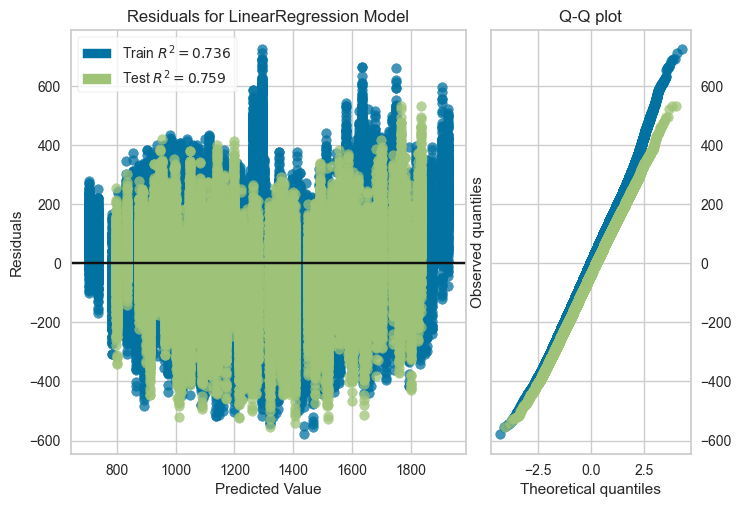

C:\Users\freya\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


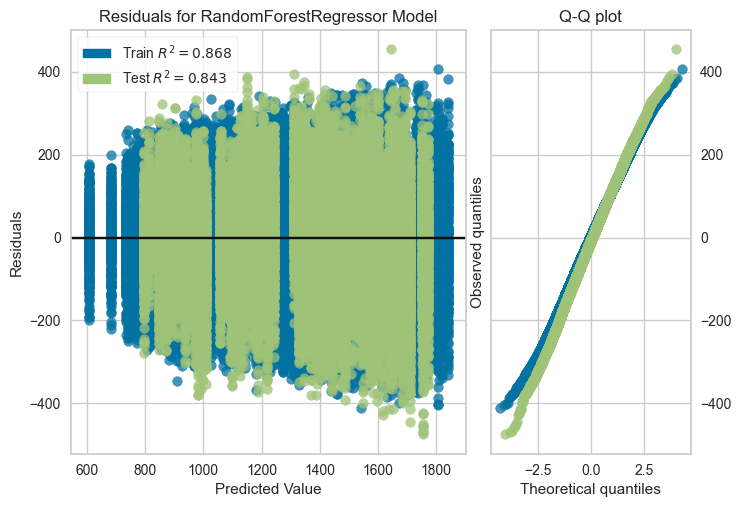

C:\Users\freya\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


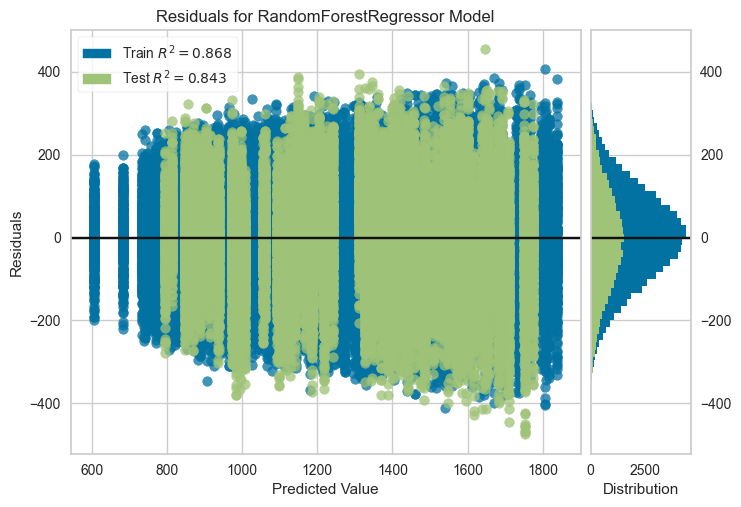

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [279]:
visualizer = ResidualsPlot(linearmodel, hist=False, qqplot = True)

visualizer.fit(training["Input"], training["Output"][variable_to_predict])  # Fit the training data to the visualizer
visualizer.score(test["Input"], test["Output"][variable_to_predict])  # Evaluate the model on the test data
visualizer.show()    

visualizer = ResidualsPlot(model, hist=False, qqplot = True)

visualizer.fit(training["Input"], training["Output"][variable_to_predict])  # Fit the training data to the visualizer
visualizer.score(test["Input"], test["Output"][variable_to_predict])  # Evaluate the model on the test data
visualizer.show()     

visualizer = ResidualsPlot(model, hist=True, qqplot = False)

visualizer.fit(training["Input"], training["Output"][variable_to_predict])  # Fit the training data to the visualizer
visualizer.score(test["Input"], test["Output"][variable_to_predict])  # Evaluate the model on the test data
visualizer.show()     